# CS162 Final Project: Human vs. AI Text Detection - Evaluation Pipeline

**Author:** Ryan Phua, Zinnia Kwan, Nicole Ju, Peilin Rao

In [ ]:
# to run this model properly, see == USER CONFIGURATION == after the feature_utils.py below

In [ ]:
%%writefile feature_utils.py
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords, words as nltk_words
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import Counter, defaultdict
import re
import textstat
from textblob import TextBlob
import spacy

# --- Globals and Models ---
nlp = spacy.load("en_core_web_sm")
english_vocab = set(nltk_words.words())

# These lists ensure the feature set is always consistent.
# The number of items here directly determines the number of features produced.
FIXED_POS_TAGS = ['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN',
                  'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM',
                  'VERB', 'X', 'SPACE'] # 18 items


FIXED_PUNCT_MARKS = ['.', ',', ';', ':', '?', '!', '"', '(', ')', '-', '—'] # 11 items
# =======================


# --- Helper Functions ---
def average_word_length(words):
    return np.mean([len(w) for w in words]) if words else 0

def type_token_ratio(words):
    return len(set(words)) / len(words) if words else 0

def hapax_legomena(words):
    return (sum(1 for count in Counter(words).values() if count == 1)) / len(words) if words else 0

def use_of_contractions(text):
    return len(re.findall(r"(?:n't|'re|'s|'d|'ll|'ve|'m)", text))

def typo_freq(words):
    return sum(1 for w in words if w not in english_vocab) / len(words) if words else 0

def parse_tree_depth(doc):
    sentence_depths = []
    for sent in doc.sents:
        token_depths = [len(list(tok.ancestors)) for tok in sent]
        if token_depths:
            avg_depth = sum(token_depths) / len(token_depths)
            sentence_depths.append(avg_depth)
    return np.mean(sentence_depths) if sentence_depths else 0

def syntactic_surprise(pos_tags):
    bigrams = list(nltk.bigrams(pos_tags))
    if not bigrams: return 0
    bigram_freq = Counter(bigrams)
    probs = [bigram_freq[bg] / len(bigrams) for bg in bigrams]
    return -np.sum([p * np.log2(p) for p in probs if p > 0])

def subordinate_clause_ratio(doc):
    num_sents = len(list(doc.sents))
    return sum(1 for tok in doc if tok.dep_ == 'mark') / num_sents if num_sents > 0 else 0

def avg_sentence_length(sentences):
    return np.mean([len(word_tokenize(s)) for s in sentences]) if sentences else 0

def capitalization_ratio(not_lowercased_words):
    return sum(1 for w in not_lowercased_words if w and w[0].isupper()) / len(not_lowercased_words) if not_lowercased_words else 0

def flesch(text):
    return textstat.flesch_reading_ease(text)

def fog(text):
    return textstat.gunning_fog(text)

def compute_burstiness(words):
    if not words: return 0
    word_positions = defaultdict(list)
    for i, w in enumerate(words):
        word_positions[w].append(i)
    std_diffs = [np.std(np.diff(pos)) if len(pos) > 1 else 0 for pos in word_positions.values()]
    return np.mean(std_diffs) if std_diffs else 0

def repetition_score(words):
    if not words: return 0
    freq = Counter(words)
    return max(freq.values()) / len(words)

# --- Robust Dictionary-based Feature Functions ---
def pos_distribution(doc):
    pos_counts = Counter(token.pos_ for token in doc)
    total = sum(pos_counts.values())
    return {f"pos_distribution.{tag}": pos_counts.get(tag, 0) / total if total > 0 else 0
            for tag in FIXED_POS_TAGS}

def punctuation_freq(text):
    total_chars = len(text.replace(" ", ""))
    return {f"punctuation_usage.{p}": text.count(p) / total_chars if total_chars > 0 else 0
            for p in FIXED_PUNCT_MARKS}

def ngram_diversity(words, n=2):
    total_ngrams = len(words) - n + 1
    if total_ngrams <= 0: return 0
    unique_ngrams = len(set(tuple(words[i:i+n]) for i in range(total_ngrams)))
    return unique_ngrams / total_ngrams

def char_ngram_diversity(text, n=3):
    chars = re.sub(r'\s+', '', text)
    total = len(chars) - n + 1
    if total <= 0: return 0
    unique_ngrams = len(set(chars[i:i+n] for i in range(total)))
    return unique_ngrams / total if total > 0 else 0


# --- Main Feature Extraction Function ---
def extract_features(text):
    """
    This is the main function that generates a dictionary of all features.
    It will produce exactly 47 features: 18 core + 18 POS + 11 Punctuation.
    """
    if not isinstance(text, str):
        text = ""

    doc = nlp(text)
    words = [w.lower() for w in word_tokenize(text) if w.isalpha()]
    not_lowercased_words = [w for w in word_tokenize(text) if w.isalpha()]
    sentences = sent_tokenize(text)
    # Use NLTK for POS tagging to match the original training script's likely behavior
    pos_tags = [tag for word, tag in nltk.pos_tag(words)]

    char_trigrams = [text[i:i+3] for i in range(len(text)-2)]
    word_bigrams = [tuple(words[i:i+2]) for i in range(len(words)-1)]
    char_trigram_counts = Counter(char_trigrams)
    word_bigram_counts = Counter(word_bigrams)
    total_char_trigrams = len(char_trigrams)
    total_word_bigrams = len(word_bigrams)

    # Assemble the 18 core features
    features = {
        "avg_word_length": average_word_length(words),
        "type_token_ratio": type_token_ratio(words),
        "hapax_legomena": hapax_legomena(words),
        "char_ngram_diversity": char_ngram_diversity(text, 3),
        "char_ngram_entropy": -np.sum([(freq/total_char_trigrams) * np.log2(freq/total_char_trigrams) for freq in char_trigram_counts.values() if freq > 0]) if total_char_trigrams > 0 else 0,
        "word_bigram_diversity": ngram_diversity(words, 2),
        "word_bigram_entropy": -np.sum([(freq/total_word_bigrams) * np.log2(freq/total_word_bigrams) for freq in word_bigram_counts.values() if freq > 0]) if total_word_bigrams > 0 else 0,
        "contraction_ratio": use_of_contractions(text) / len(words) if words else 0,
        "typos": typo_freq(words),
        "tree_depth": parse_tree_depth(doc),
        "syntactic_surprise": syntactic_surprise(pos_tags),
        "subordinate_ratio": subordinate_clause_ratio(doc),
        "avg_sentence_length": avg_sentence_length(sentences),
        "capitalization_ratio": capitalization_ratio(not_lowercased_words),
        "flesch": flesch(text),
        "fog": fog(text),
        "burstiness": compute_burstiness(words),
        "repetition_score": repetition_score(words)
    }

    # Add the dictionary-based features (18 POS + 11 Punctuation)
    features.update(pos_distribution(doc))
    features.update(punctuation_freq(text))

    return features

# --- Wrapper for Parallel Processing ---
def apply_feature_extraction_to_row(row):
    """
    A simple wrapper for pandarallel.
    """
    return extract_features(row['text'])

Writing feature_utils.py


In [ ]:
# ========= USER CONFIGURATION =================================================
# --- Path to the input dataset files ---
INPUT_FILES = [
    "DevSet/reddit_cohere.jsonl",
    "DevSet/reddit_chatGPT.jsonl",
    "DevSet/arxiv_cohere.jsonl",
    "DevSet/arxiv_chatGPT.jsonl"
]

# plase locate this line
# "df = df.sample(frac=..., random_state=42).reset_index(drop=True)"
# and change to a different fraction of the test set to speed up the process

# --- Path to the output directory ---
OUTPUT_DIR = "evaluation_results"

# --- Hugging Face Model Repository ---
MODEL_REPO_ID = "aefsafefesf/final_classifier_model_CS162_AI_detection"
MODEL_FILENAME = "final_classifier_model.pt"

# --- Gemini API Configuration for Semantic Embeddings ---
GENERATE_SEMANTIC_EMBEDDINGS = True


In [ ]:
!pip install spacy nltk textstat transformers torch pandas seaborn matplotlib textblob huggingface_hub tqdm google-generativeai pandarallel python-dotenv
!python -m nltk.downloader punkt stopwords averaged_perceptron_tagger wordnet words
!python -m spacy download en_core_web_sm

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 43.8 MB/s eta 0:00:00


In [ ]:
!python -m nltk.downloader punkt_tab

<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
!python -m nltk.downloader averaged_perceptron_tagger_eng

<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [ ]:
# ==============================================================================
#
# ========= I. INSTALL DEPENDENCIES & SETUP ====================================
#
# ==============================================================================
print("--- Section I: Installing Dependencies & Setup ---")


import os
import json
import re
import time
import ast
from collections import Counter, defaultdict

import pandas as pd
import numpy as np
from tqdm import tqdm
from pandarallel import pandarallel

import nltk
from nltk.corpus import stopwords, words as nltk_words

import spacy
import textstat
import google.generativeai as genai

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_curve, auc, confusion_matrix)
import seaborn as sns
import matplotlib.pyplot as plt

from huggingface_hub import hf_hub_download
from feature_utils import apply_feature_extraction_to_row # Assumes feature_utils.py is in the same directory

# Initialize libraries
print("Loading NLP models...")
nlp = spacy.load("en_core_web_sm")
tqdm.pandas()
pandarallel.initialize(progress_bar=True, nb_workers=os.cpu_count() // 2)

# Ensure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Dependencies loaded. Output will be saved to: {OUTPUT_DIR}")


--- Section I: Installing Dependencies & Setup ---
Loading NLP models...
INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Dependencies loaded. Output will be saved to: evaluation_results


In [ ]:
# ==============================================================================
#
# ========= II. LOAD DATA ======================================================
#
# ==============================================================================
print("\n--- Section II: Loading Data ---")

all_data = []
print(f"Loading data from {len(INPUT_FILES)} file(s)...")
for file_path in INPUT_FILES:
    try:
        with open(file_path, 'r') as f:
            for line in f:
                all_data.append(json.loads(line))
        print(f"Successfully loaded {file_path}")
    except FileNotFoundError:
        print(f"ERROR: File not found at {file_path}. Please check the path.")
        exit()

# Convert to DataFrame
df = pd.DataFrame(all_data)

# Extract human and AI text into separate DataFrames
human = df[['human_text']].copy()
human['label'] = 0
human.rename(columns={'human_text': 'text'}, inplace=True)

ai = df[['machine_text']].copy()
ai['label'] = 1
ai.rename(columns={'machine_text': 'text'}, inplace=True)

# Combine into one DataFrame
df = pd.concat([human, ai], ignore_index=True)
# For quick testing, you can uncomment the line below to use a subset of the data

# TEMPORARY: to let the model run very fast set frac = 0.01 or lower.

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Data loaded and combined. Total samples: {len(df)}")



--- Section II: Loading Data ---
Loading data from 4 file(s)...
Successfully loaded DevSet/reddit_cohere.jsonl
Successfully loaded DevSet/reddit_chatGPT.jsonl
Successfully loaded DevSet/arxiv_cohere.jsonl
Successfully loaded DevSet/arxiv_chatGPT.jsonl
Data loaded and combined. Total samples: 24000


In [ ]:
# ==============================================================================
#
# ========= III. FEATURE EXTRACTION: SEMANTIC (from Original Text) =============
#
# ==============================================================================
print("\n--- Section III: Generating Semantic Features from ORIGINAL text ---")

semantic_output_path = os.path.join(OUTPUT_DIR, 'dev_semantic_embeddings.csv')

if GENERATE_SEMANTIC_EMBEDDINGS:
    # --- Load API Key from Colab Secrets ---
    try:
        from google.colab import userdata
        GEMINI_API_KEY = userdata.get('GEMINI_API_KEY') # Or can manually set a Gemini API KEY
        if not GEMINI_API_KEY:
            raise ValueError("API Key not found in Colab Secrets.")
        print("Successfully loaded Gemini API key from Colab Secrets.")
    except ImportError:
        print("FATAL ERROR: This notebook is designed to run in Google Colab. Please use Colab Secrets to store your API key.")
        exit()
    except ValueError as e:
        print(f"FATAL ERROR: {e}")
        print("Please click the 'key' icon on the left, add a new secret named 'GEMINI_API_KEY', and paste your key in the 'Value' field.")
        exit()

    # --- Configure Gemini API ---
    try:
        genai.configure(api_key=GEMINI_API_KEY)
        print("Gemini API configured successfully.")

        def generate_gemini_semantic_embeddings(texts, batch_size=100):
            all_embeddings = []
            for i in tqdm(range(0, len(texts), batch_size), desc="Generating Gemini embeddings"):
                batch_texts = [str(text) if pd.notna(text) and str(text).strip() else " " for text in texts[i:i + batch_size]]
                try:
                    response = genai.embed_content(
                        model="models/text-embedding-004",
                        content=batch_texts,
                        task_type="CLASSIFICATION"
                    )
                    all_embeddings.extend(response['embedding'])
                except Exception as e:
                    print(f"An error occurred in batch starting at index {i}: {e}")
                    all_embeddings.extend([np.zeros(768).tolist()] * len(batch_texts))
                time.sleep(1) # Rate limiting
            return np.array(all_embeddings)

        semantic_embeddings = generate_gemini_semantic_embeddings(df['text'].tolist())
        semantic_df = pd.DataFrame({
            'label': df['label'],
            'embedding': [emb.tolist() for emb in semantic_embeddings]
        })
        semantic_df.to_csv(semantic_output_path, index=False)
        print(f"Saved semantic embeddings with shape: {semantic_embeddings.shape} to {semantic_output_path}")

    except Exception as e:
        print(f"An unexpected error occurred during semantic embedding generation: {e}")
        exit()
else:
    print(f"Loading pre-generated semantic embeddings from {semantic_output_path}...")
    semantic_df = pd.read_csv(semantic_output_path)
    semantic_df['embedding'] = semantic_df['embedding'].progress_apply(ast.literal_eval)
    print("Successfully loaded pre-generated semantic embeddings.")



--- Section III: Generating Semantic Features from ORIGINAL text ---
Successfully loaded Gemini API key from Colab Secrets.
Gemini API configured successfully.


Generating Gemini embeddings: 100%|██████████| 240/240 [16:20<00:00,  4.09s/it]


Saved semantic embeddings with shape: (24000, 768) to evaluation_results/dev_semantic_embeddings.csv


In [ ]:
# ==============================================================================
#
# ========= IV. FEATURE EXTRACTION: STYLOMETRIC (from Processed Text) =========
#
# ==============================================================================
print("\n--- Section IV: Preprocessing and Generating Stylometric Features ---")

# Step 1: Preprocess text specifically for stylometric analysis
print("Applying stylometric-specific preprocessing...")
def preprocess_text(text):
    if not isinstance(text, str): return ""
    tokens = nltk.word_tokenize(text)
    return ' '.join(tokens)

processed_text_for_stylo = df['text'].progress_apply(preprocess_text)

# Step 2: Generate stylometric features from the PROCESSED text
print("Generating stylometric features from PREPROCESSED text...")

# Create a temporary DataFrame for parallel processing
temp_df_for_stylo = pd.DataFrame({'text': processed_text_for_stylo})

stylometric_features_list = temp_df_for_stylo.parallel_apply(
    apply_feature_extraction_to_row, axis=1
)

stylometric_features_df = pd.DataFrame(stylometric_features_list.tolist())
stylometric_features_df.fillna(0, inplace=True)
print(f"Generated {stylometric_features_df.shape[1]} stylometric features.")



--- Section IV: Preprocessing and Generating Stylometric Features ---
Applying stylometric-specific preprocessing...


100%|██████████| 24000/24000 [00:46<00:00, 516.95it/s]

Generating stylometric features from PREPROCESSED text...


Generated 47 stylometric features.


In [ ]:
# ==============================================================================
#
# ========= V. MODEL DEFINITION & ATTENTION MECHANISM ==========================
#
# ==============================================================================
print("\n--- Section V: Defining Model Architecture ---")


class SelfAttention(nn.Module):
    """
    Self-attention mechanism for stylometric features.
    This is the manual implementation that matches saved model checkpoint.
    """
    def __init__(self, embed_dim, num_heads=4):
        super(SelfAttention, self).__init__()
        # Ensure num_heads divides embed_dim evenly
        if embed_dim > 0 and embed_dim % num_heads != 0:
            for i in range(num_heads, 0, -1):
                if embed_dim % i == 0:
                    num_heads = i
                    break
            else: # If no divisor found, use 1 head
                num_heads = 1
        elif embed_dim == 0: # Handle edge case of 0 dimension
             num_heads = 1

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads if num_heads > 0 else 0
        self.scale = self.head_dim ** -0.5 if self.head_dim > 0 else 1

        # These layers match the keys in saved checkpoint
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        batch_size = x.shape[0]
        # Add sequence dimension if missing (B, D) -> (B, 1, D)
        x = x.unsqueeze(1) if x.dim() == 2 else x
        seq_length = x.shape[1]

        q = self.query(x).view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.key(x).view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.value(x).view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        attn_weights = torch.nn.functional.softmax(scores, dim=-1)
        attn_output = torch.matmul(attn_weights, v)

        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_length, self.embed_dim)
        output = self.out_proj(attn_output)

        # Remove sequence dimension (B, 1, D) -> (B, D)
        return output.squeeze(1)


class TextClassifier(nn.Module):
    """Complete text classifier with attention mechanism"""
    def __init__(self, semantic_dim, stylometric_dim, hidden_dims, dropout_rate):
        super(TextClassifier, self).__init__()
        # This now correctly uses the manual SelfAttention implementation
        self.stylometric_attention = SelfAttention(embed_dim=stylometric_dim)

        layers = []
        input_dim = semantic_dim + stylometric_dim
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            input_dim = hidden_dim
        layers.extend([nn.Linear(input_dim, 1), nn.Sigmoid()])
        self.mlp_layers = nn.Sequential(*layers)

    def forward(self, semantic_embed, stylometric_embed):
        attended_stylometric = self.stylometric_attention(stylometric_embed)
        combined_embed = torch.cat([semantic_embed, attended_stylometric], dim=1)
        return self.mlp_layers(combined_embed)

print("Model architecture defined.")




--- Section V: Defining Model Architecture ---
Model architecture defined.


In [ ]:
# ==============================================================================
#
# ========= VI. LOAD PRE-TRAINED MODEL & PREPARE FOR EVALUATION ================
#
# ==============================================================================
print("\n--- Section VI: Loading Pre-trained Model and Preparing Data ---")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

try:
    print(f"Downloading model '{MODEL_FILENAME}' from repository '{MODEL_REPO_ID}'...")
    model_path = hf_hub_download(repo_id=MODEL_REPO_ID, filename=MODEL_FILENAME)
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    print("Model checkpoint downloaded and loaded successfully.")
except Exception as e:
    print(f"FATAL ERROR: Could not download or load the model. Details: {e}")
    exit()

# --- Validate Checkpoint and Normalize Stylometric Features ---
if 'scaler_feature_names' not in checkpoint:
    raise ValueError("FATAL: Checkpoint is missing 'scaler_feature_names'. Please regenerate it with the corrected training script.")

TRAINING_FEATURE_NAMES = checkpoint['scaler_feature_names']
print(f"Loaded {len(TRAINING_FEATURE_NAMES)} feature names from the checkpoint to ensure order.")

# Reorder the DataFrame to GUARANTEE it matches the model's expected training order
stylometric_features_df_reordered = stylometric_features_df[TRAINING_FEATURE_NAMES]
print("Feature set validated and reordered to match model's expectations.")

new_scaler = StandardScaler()
stylometric_features_normalized = pd.DataFrame(
    new_scaler.fit_transform(stylometric_features_df_reordered.values), # Use fit_transform here
    columns=TRAINING_FEATURE_NAMES
)
print("Stylometric features have been normalized.")


# --- Initialize Model ---
model = TextClassifier(**checkpoint['model_config'])
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()
print("Model instantiated with weights from checkpoint.")

# --- Create Evaluation Dataset and DataLoader ---
class EvaluationDataset(Dataset):
    def __init__(self, semantic_df, stylometric_df_normalized, original_texts):
        self.semantic_embeddings = torch.tensor(semantic_df['embedding'].tolist(), dtype=torch.float32)
        self.stylometric_embeddings = torch.tensor(stylometric_df_normalized.values, dtype=torch.float32)
        self.labels = torch.tensor(semantic_df['label'].values, dtype=torch.long)
        self.texts = original_texts
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        return {
            'text': self.texts[idx],
            'semantic': self.semantic_embeddings[idx],
            'stylometric': self.stylometric_embeddings[idx],
            'label': self.labels[idx]
        }

eval_dataset = EvaluationDataset(semantic_df, stylometric_features_normalized, df['text'].values)
eval_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False)
print(f"Created evaluation dataset with {len(eval_dataset)} samples.")



--- Section VI: Loading Pre-trained Model and Preparing Data ---
Using device: cpu


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


final_classifier_model.pt:   0%|          | 0.00/497k [00:00<?, ?B/s]

Model checkpoint downloaded and loaded successfully.
Loaded 47 feature names from the checkpoint to ensure order.
Feature set validated and reordered to match model's expectations.
Stylometric features have been normalized.
Model instantiated with weights from checkpoint.
Created evaluation dataset with 24000 samples.



--- Section VII: Evaluating Model and Visualizing Results ---


Evaluating model: 100%|██████████| 750/750 [00:06<00:00, 116.08it/s]



EVALUATION RESULTS
Accuracy:  0.8858
Precision: 0.9976
Recall:    0.7734
F1 Score:  0.8713
AUC:       0.9554


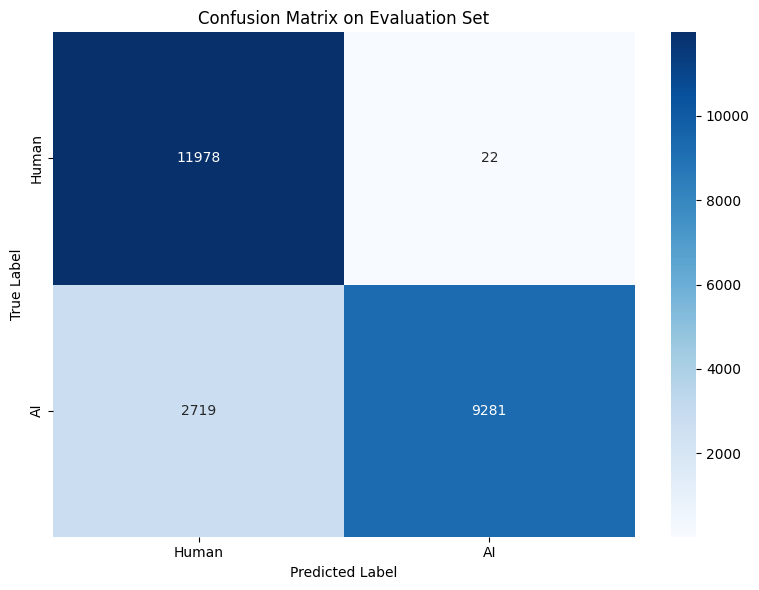

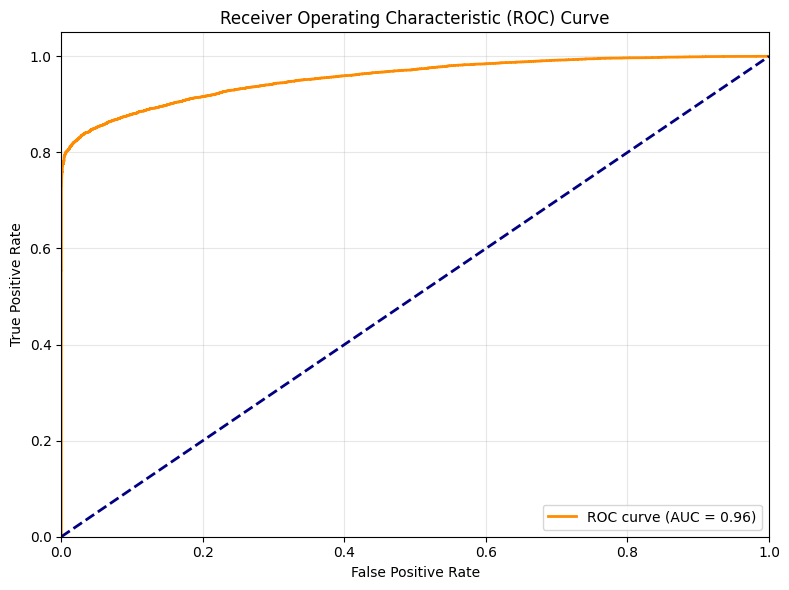

Detailed prediction results saved to evaluation_results/dev_predictions.csv

--- Evaluation Complete ---


In [ ]:
# ==============================================================================
#
# ========= VII. EVALUATE MODEL & VISUALIZE RESULTS ============================
#
# ==============================================================================
print("\n--- Section VII: Evaluating Model and Visualizing Results ---")

all_preds, all_labels, all_probs = [], [], []
with torch.no_grad():

    for batch in tqdm(eval_loader, desc="Evaluating model"):
        semantic_embed = batch['semantic'].to(device)
        stylometric_embed = batch['stylometric'].to(device)
        labels = batch['label'].float().to(device)
        outputs = model(semantic_embed, stylometric_embed).squeeze()
        probs = outputs.cpu().numpy()
        preds = (probs >= 0.5).astype(int)
        all_probs.extend(probs)
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy().astype(int))

# Calculate and Print Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, zero_division=0)
recall = recall_score(all_labels, all_preds, zero_division=0)
f1 = f1_score(all_labels, all_preds, zero_division=0)
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

print("\n" + "="*50)
print("EVALUATION RESULTS")
print("="*50)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC:       {roc_auc:.4f}")
print("="*50)

# Plot and Save Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(all_labels, all_preds), annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Evaluation Set')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'dev_confusion_matrix.png'))
plt.show()

# Plot and Save ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right"); plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'dev_roc_curve.png'))
plt.show()

# Save Detailed Predictions
results_df = pd.DataFrame({
    'text': eval_dataset.texts,
    'true_label': all_labels,
    'predicted_label': all_preds,
    'probability_ai': all_probs
})
results_df.to_csv(os.path.join(OUTPUT_DIR, 'dev_predictions.csv'), index=False)
print(f"Detailed prediction results saved to {os.path.join(OUTPUT_DIR, 'dev_predictions.csv')}")

print("\n--- Evaluation Complete ---")